# Lensing Background Galaxies by Foreground Halos

#### Spencer Everett, SLAC 7/29/2015

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import os,sys
import pyfits
import matplotlib.pyplot as plt
import cmath
import cPickle as pickle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
%matplotlib inline

In [3]:
# Pangloss:
PANGLOSS_DIR = os.path.expandvars("$PANGLOSS_DIR")
sys.path.append(PANGLOSS_DIR)
import pangloss

Import the convergence and shear maps:

In [4]:
K = pangloss.Kappamap(PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.kappa',FITS=False)

In [5]:
S = pangloss.Shearmap([PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_1',PANGLOSS_DIR+'/data/GGL_los_8_0_0_N_4096_ang_4_rays_to_plane_37_f.gamma_2'],FITS=False)

Import the foreground galaxy catalog for the (8,0,0,0) field:

In [6]:
config = pangloss.Configuration(PANGLOSS_DIR+'/example/example.config')
F = pangloss.ForegroundCatalog(PANGLOSS_DIR+'/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt',config)

['/Users/user/Code/Pangloss/calib/Millennium/catalog_example.txt']
['/Users/user/Code/Pangloss/calib/Millennium/GGL_los*.fits']


OK! We are all set, with ray traced mass and shear maps, plus the corresponding catalog of foreground halos. 

## Making a WL Background Galaxy Ellipticity Catalog
Let's generate a background galaxy catalog in a small part of the field with 10 sources per square arcminute:

In [7]:
# d = [1.85,1.15,-1.85,-1.15] # 40 x 40 sq arcmin, roughly the Subaru field
# d = [1.65,1.35,-1.65,-1.35] # 18 x 18 sq arcmin, for testing
d = [1.55,1.52,-1.61,-1.59] # 1.8 x 1.2 sq arcmin, for faster testing!
B = pangloss.BackgroundCatalog(N=20.0,sigma_e=0.01,domain=d,field=[0,0,0,0])
B.lens_by_map(K,S)
print "No. of background galaxies in the field = ",B.galaxy_count

No. of background galaxies in the field =  43


## Predicting Shear with Halos
Now, let's give each background catalog a lightcone of halos in front of it, and use those halos to predict the shear that has been applied to it.

In [8]:
B.drill_lightcones(foreground=F,save=False)

0   0.0 %
5   11.0 %
10   23.0 %
15   34.0 %
20   46.0 %
25   58.0 %
30   69.0 %
35   81.0 %
40   93.0 %


In [9]:
galaxy_counts = [B.lightcones[i].galaxy_count for i in range(len(B.lightcones))]
mean_galaxies = np.mean(galaxy_counts)
std_galaxies = np.std(galaxy_counts)
print "No. of foreground galaxies per lightcone = ",int(mean_galaxies),'+/-',int(std_galaxies)

No. of foreground galaxies per lightcone =  607 +/- 19


In [10]:
B.lens_by_halos()

0   0.0 %
5   11.0 %
10   23.0 %
15   34.0 %
20   46.0 %
25   58.0 %
30   69.0 %
35   81.0 %
40   93.0 %
average CPU time per background galaxy:  0.548070813334 +/- 0.0616743512748


OK! Let's see what the ray traced shear field (red), observed (but noise-free) ellipticties (green), and halo-predicted shears (purple) look like:

/Users/user/Code/Pangloss/pangloss/kappamap.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Kmin = np.min(self.values[0][pix_yi:pix_yf,pix_xi:pix_xf])
/Users/user/Code/Pangloss/pangloss/kappamap.py:86: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Kmax = np.max(self.values[0][pix_yi:pix_yf,pix_xi:pix_xf])
/Users/user/Code/Pangloss/pangloss/shearmap.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  gamma1 = self.values[0][pix_yi:pix_yf,pix_xi:pix_xf]
/Users/user/Code/Pangloss/pangloss/shearmap.py:119: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  gamma2 = self.values[1][pix_yi:pix_yf,pix_xi:pix_xf]


UnboundLocalError: local variable 'world' referenced before assignment

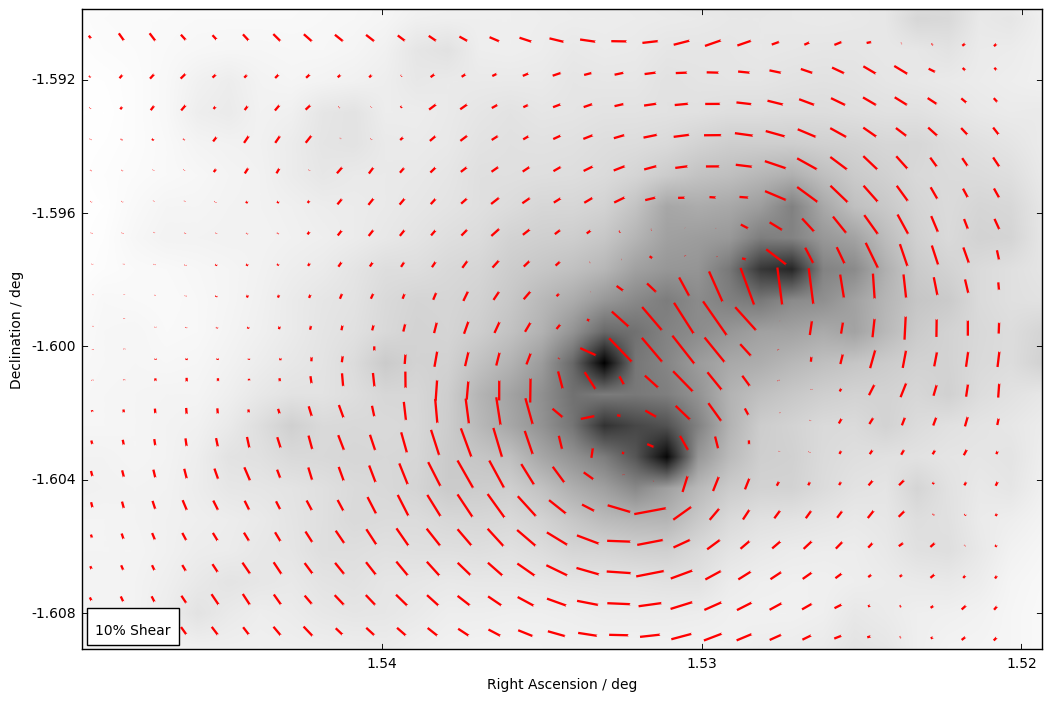

In [11]:
K.plot(fig_size=12,subplot=[1.55,1.52,-1.61,-1.59])
S.plot()
B.plot(lensed='all',graph='stick')

## Comparing the Ray-traced and Halo-predicted Mass Maps

In progress..

In [12]:
true_kappamap,true_shearmap = B.bin_to_maps(lensed='map')
predicted_kappamap,predicted_shearmap = B.bin_to_maps(lensed='halo')

/Users/user/Code/Pangloss/pangloss/background.py:726: RuntimeWarning: invalid value encountered in divide
  kappadata[0] = 1.0*H/N


ValueError: could not broadcast input array from shape (23,14) into shape (14,23)

In [13]:
print true_kappamap

NameError: name 'true_kappamap' is not defined

## Summarizing Shear Fields with Correlation Functions

In [14]:
gg_int = B.calculate_corr(corr_type='gg',lensed='none',max_sep=5)
gg_map = B.calculate_corr(corr_type='gg',lensed='map',max_sep=5)
gg_halo = B.calculate_corr(corr_type='gg',lensed='halo',max_sep=5)

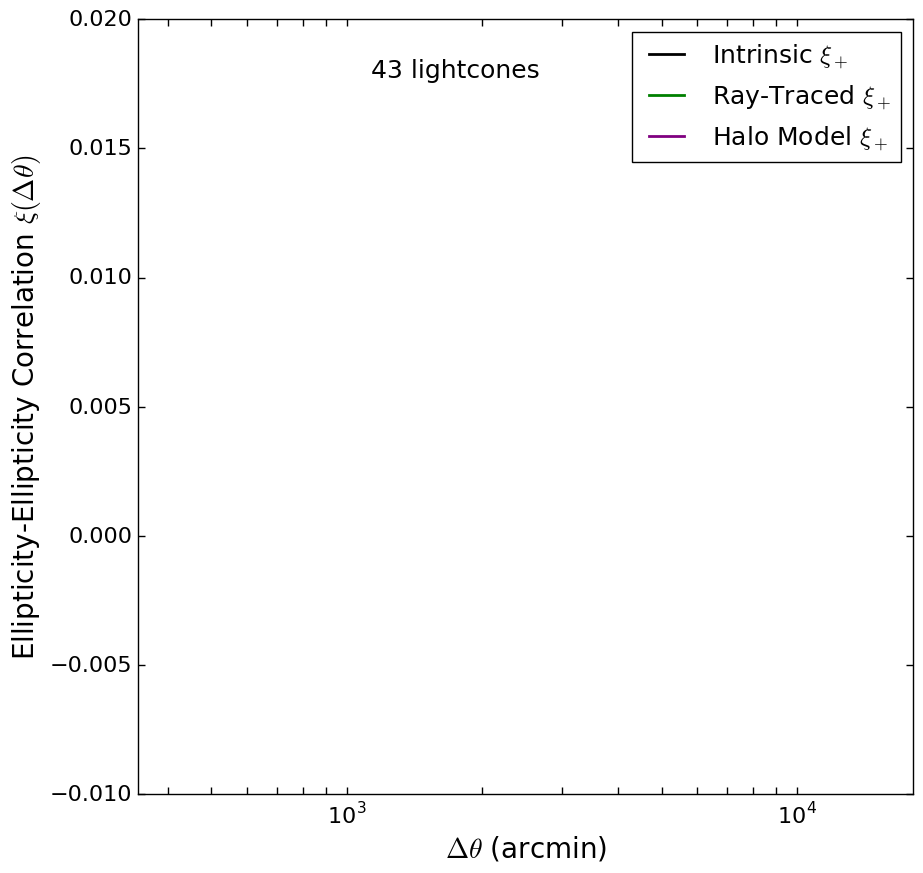

In [15]:
pangloss.plotting.plot_corr(gg_int,corr_type='gg',corr_comp='plus',lensed='none',color='black',galaxy_count=B.galaxy_count)
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='plus',lensed='map',color='green')
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='plus',lensed='halo',color='purple')

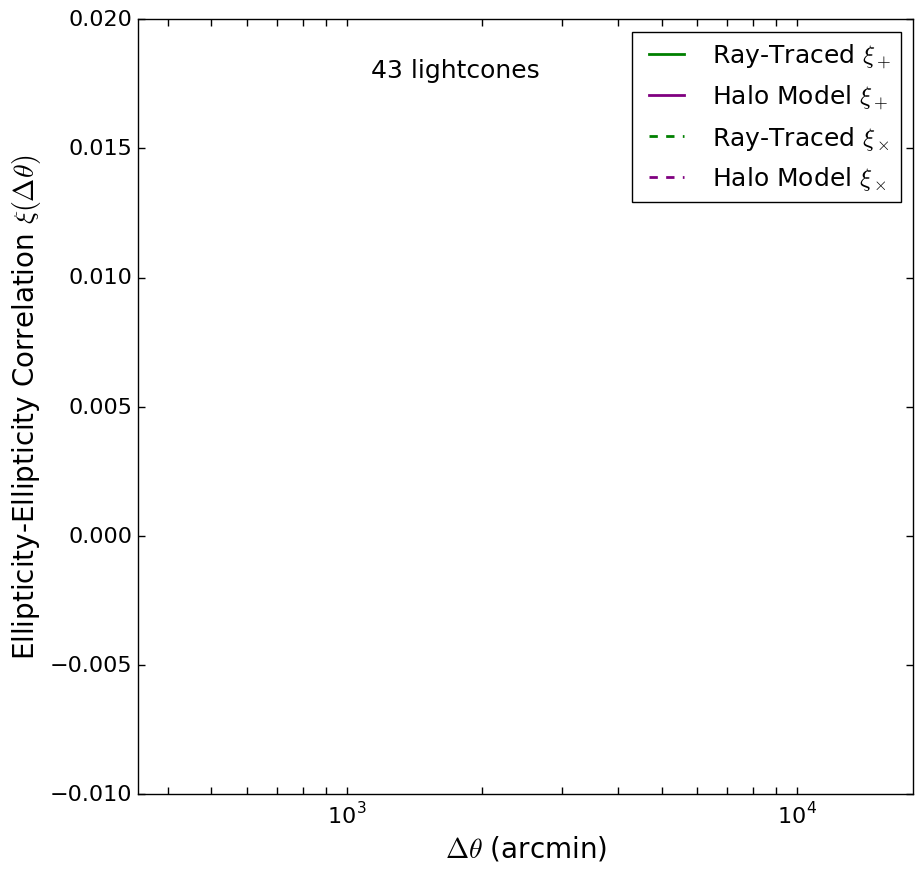

In [16]:
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='plus',lensed='map',color='green',galaxy_count=B.galaxy_count)
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='plus',lensed='halo',color='purple')
pangloss.plotting.plot_corr(gg_map,corr_type='gg',corr_comp='cross',lensed='map',color='green')
pangloss.plotting.plot_corr(gg_halo,corr_type='gg',corr_comp='cross',lensed='halo',color='purple')